In [1]:
import cv2
import re
import numpy as np
import os
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, Bidirectional,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

def mediapipe_detection(image, holistic_model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = holistic_model.process(image)        # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def extract_keypoints(results):
    if results.right_hand_landmarks:
        rh = np.array([[res.x, res.y] for res in results.right_hand_landmarks.landmark])
    else:
        rh = np.zeros((21, 2))  
    return rh


def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [3]:
def normalize_keypoints(keypoints):
    # Kiểm tra nếu có đủ số điểm (21 điểm cho mỗi bàn tay)
    if keypoints.shape[0] != 21:
        raise ValueError(f"Số lượng điểm keypoints không hợp lệ: {keypoints.shape[0]}")

    # Cổ tay là điểm đầu tiên trong keypoints (index 0)
    wrist = keypoints[0]
    
    # Dịch các điểm sao cho cổ tay trở thành gốc tọa độ (0, 0)
    normalized_keypoints = []
    for point in keypoints:
        normalized_point = (point[0] - wrist[0], point[1] - wrist[1])  # Chỉ cần dịch x, y
        normalized_keypoints.append(normalized_point)
    
    normalized_keypoints = np.array(normalized_keypoints)
    
    # x_min, y_min = np.min(normalized_keypoints, axis=0)
    # x_max, y_max = np.max(normalized_keypoints, axis=0)
    
    # if (x_max - x_min) == 0:
    #     print("Cảnh báo: Tọa độ x không thay đổi, bỏ qua chuẩn hóa x.")
    #     x_min, x_max = 0, 1  # Cứ để giá trị x giữ nguyên, hoặc chọn giá trị mặc định
    # if (y_max - y_min) == 0:
    #     print("Cảnh báo: Tọa độ y không thay đổi, bỏ qua chuẩn hóa y.")
    #     y_min, y_max = 0, 1  # Cứ để giá trị y giữ nguyên, hoặc chọn giá trị mặc định
    
    # min_vals = np.array([x_min, y_min])
    # max_vals = np.array([x_max, y_max])
    
    # normalized_keypoints = (normalized_keypoints - min_vals) / (max_vals - min_vals)
    
    return normalized_keypoints

In [7]:
def process_npy(action):    
    # Khởi tạo mô hình Mediapipe Holistic
    with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
        
        # Lấy danh sách tất cả video trong thư mục của action cụ thể
        video_folder = f'data/{action}'
        videos = [f for f in os.listdir(video_folder) if f.endswith('.avi')]
        
        for videoCounter, videoFile in enumerate(videos):
            cap = cv2.VideoCapture(os.path.join(video_folder, videoFile))
            framesCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            points = []
            # Không cần skip frame nữa, xử lý tất cả frame
            for frameCounter in range(framesCount):  # Xử lý tất cả các frame trong video
                ret, frame = cap.read()
                
                if not ret:
                    break  # Nếu không đọc được frame thì dừng
                
                # Chạy Mediapipe để phát hiện landmarks
                image, results = mediapipe_detection(frame, holistic)
                
                # Hiển thị kết quả (có thể bỏ qua nếu không cần thiết)
                # cv2.imshow('OpenCV Feed', image)
                
                # Trích xuất keypoints từ kết quả Mediapipe
                keypoints = normalize_keypoints(extract_keypoints(results))
                
                #  Tạo thư mục để lưu các keypoints của video và frame hiện tại
                npy_dir = os.path.join('new_data_npy', action, str(videoCounter))
                os.makedirs(npy_dir, exist_ok=True)  # Tạo thư mục nếu chưa tồn tại
            
                npy_path = os.path.join('new_data_npy', action, str(videoCounter), str(frameCounter))
                np.save(npy_path, keypoints)
                
                # Nếu nhấn 'q', thoát khỏi quá trình xử lý
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
            
            # Giải phóng tài nguyên video sau khi xử lý xong
            cap.release()
    
    # Đóng tất cả cửa sổ OpenCV
    cv2.destroyAllWindows()

In [17]:
current_directory = os.getcwd()
print("Thư mục hiện hành là:", current_directory)

Thư mục hiện hành là: d:\Phong\Coding\GestureRecognition\interaction


In [5]:
classes = ['idle', 'chop', 'pinch']

label_map = {label:num for num, label in enumerate(classes)}
label_map

{'idle': 0, 'chop': 1, 'pinch': 2}

In [108]:
for action in classes:
    process_npy(f'{action}')

In [51]:
process_npy('idle')

In [90]:
data = np.load('new_data_npy/idle/410/3.npy')
print(data)

[[ 0.          0.        ]
 [ 0.08186767 -0.06372225]
 [ 0.14540741 -0.13288689]
 [ 0.18787482 -0.20038813]
 [ 0.21977937 -0.26005447]
 [ 0.07710418 -0.28772807]
 [ 0.09983617 -0.39939448]
 [ 0.11860833 -0.46283862]
 [ 0.13746476 -0.51478532]
 [ 0.03479517 -0.29381114]
 [ 0.04650381 -0.41817045]
 [ 0.05892158 -0.49727625]
 [ 0.07581154 -0.56062025]
 [-0.00631735 -0.27627051]
 [-0.00776598 -0.38478798]
 [ 0.00321861 -0.45332554]
 [ 0.02225477 -0.51012358]
 [-0.04913527 -0.23669231]
 [-0.06719208 -0.31788445]
 [-0.06625816 -0.37049973]
 [-0.05668113 -0.41975373]]


In [109]:
def create_dataset():   
    sequences, labels = [], []    
    for action in classes:
        
        video_folder = f'new_data_npy/{action}'
        videos = sorted([f for f in os.listdir(video_folder) if os.path.isdir(os.path.join(video_folder, f))], key=lambda x: int(x))
        
        # Lặp qua tất cả video trong folder
        for sequence in videos:
            print(sequence)
            window = []
            for frame_num in range(15):  # Giả định rằng mỗi video có n frame cần xử lý
                # Đọc file numpy của từng frame
                print(f'{action}: Loading frame {frame_num} of video {sequence}')
                res = np.load(os.path.join('new_data_npy', action, sequence, "{}.npy".format(frame_num)))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
    
    return sequences, labels

sequences, labels = create_dataset()

print(f"Tổng số sequences: {len(sequences)}")
print(f"Tổng số labels: {len(labels)}")
print(f"Shape của sequences: {np.array(sequences).shape}")
print(f"Shape của labels: {np.array(labels).shape}")

# print(sequences, labels)

0
idle: Loading frame 0 of video 0
idle: Loading frame 1 of video 0
idle: Loading frame 2 of video 0
idle: Loading frame 3 of video 0
idle: Loading frame 4 of video 0
idle: Loading frame 5 of video 0
idle: Loading frame 6 of video 0
idle: Loading frame 7 of video 0
idle: Loading frame 8 of video 0
idle: Loading frame 9 of video 0
idle: Loading frame 10 of video 0
idle: Loading frame 11 of video 0
idle: Loading frame 12 of video 0
idle: Loading frame 13 of video 0
idle: Loading frame 14 of video 0
1
idle: Loading frame 0 of video 1
idle: Loading frame 1 of video 1
idle: Loading frame 2 of video 1
idle: Loading frame 3 of video 1
idle: Loading frame 4 of video 1
idle: Loading frame 5 of video 1
idle: Loading frame 6 of video 1
idle: Loading frame 7 of video 1
idle: Loading frame 8 of video 1
idle: Loading frame 9 of video 1
idle: Loading frame 10 of video 1
idle: Loading frame 11 of video 1
idle: Loading frame 12 of video 1
idle: Loading frame 13 of video 1
idle: Loading frame 14 of vide

In [110]:
np.save("new_data.npy", sequences)
np.save("new_labels.npy", labels)

In [182]:
X = np.load('data.npy')
y = np.load('labels.npy')

print(X.shape)

X = X.reshape((X.shape[0], X.shape[1], -1))
print(X.shape)
print(y)

(1507, 15, 21, 2)
(1507, 15, 42)
[0 0 0 ... 2 2 2]


In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test.shape

# print(y_train)

(302,)

In [161]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(15, 42)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

d:\Phong\Coding\GestureRecognition\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_32 (LSTM)                  │ (None, 15, 64)         │        27,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_34 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,955 (710.76 KB)

 Trainable params: 181,955 (710.76 KB)

 Non-trainable params: 0 (0.00 B)

In [184]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(15, 42)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_41 (LSTM)                  │ (None, 15, 32)         │         9,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_42 (LSTM)                  │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,611 (143.01 KB)

 Trainable params: 36,611 (143.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)

Epoch 1/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.5052 - loss: 1.0780 - val_accuracy: 0.6432 - val_loss: 0.8199
Epoch 2/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8116 - loss: 0.5787 - val_accuracy: 0.9212 - val_loss: 0.1816


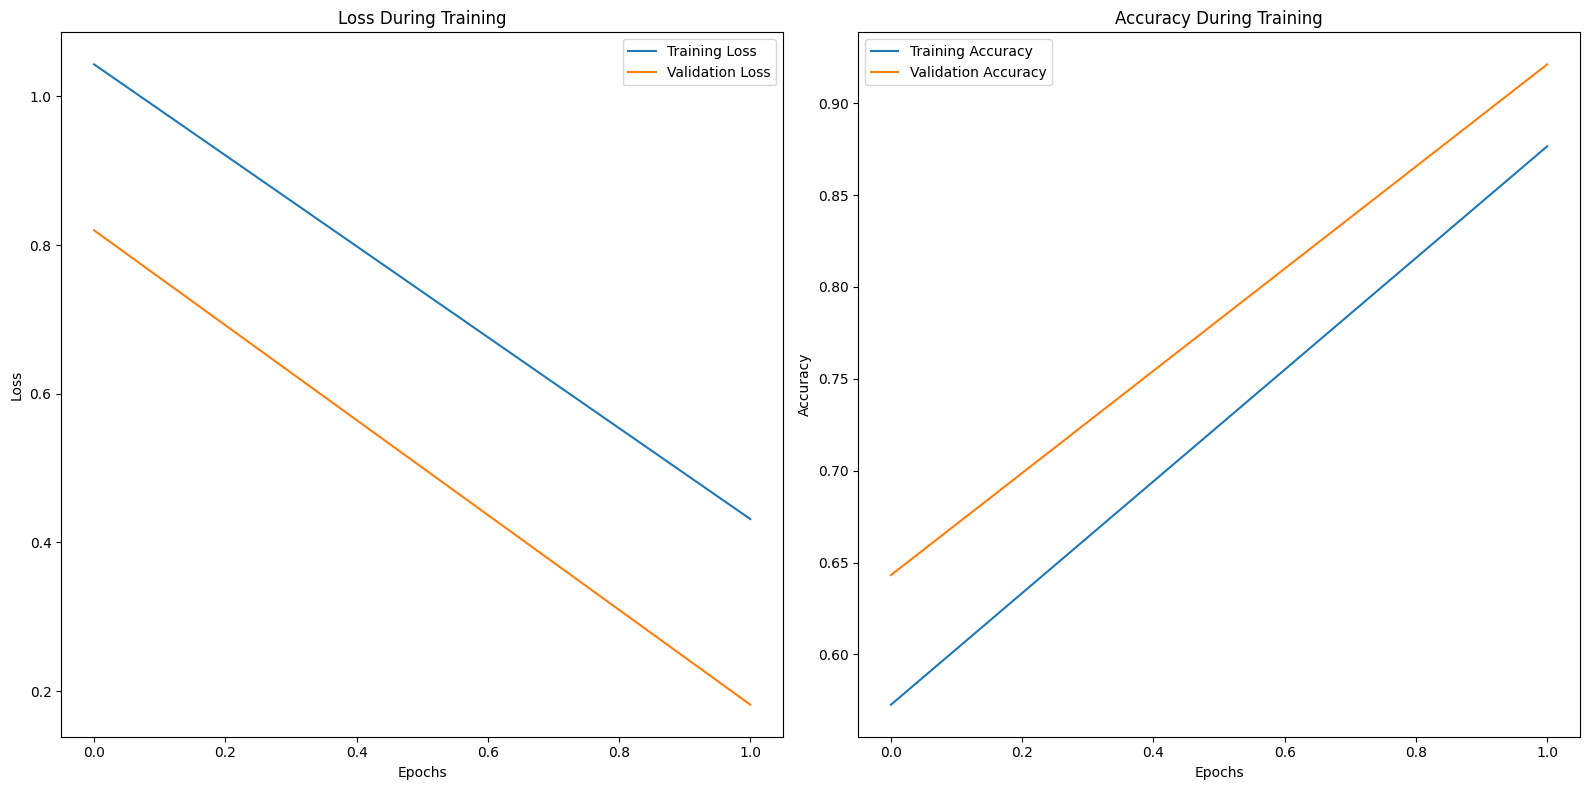

In [186]:
# Plot the loss and accuracy graphs together
plt.figure(figsize=(16, 8))

# Plot the loss graph
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy graph
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [187]:
yhat = np.argmax(model.predict(X_test), axis=1)

# print(yhat)

conf_matrix = confusion_matrix(y_test, yhat)
print(conf_matrix)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
[[103   0   6]
 [  0  89   3]
 [ 12   1  88]]


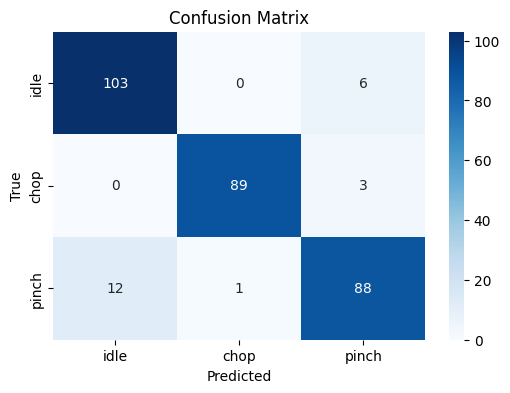

In [188]:
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [190]:
acc = accuracy_score(y_test, yhat)
precision = precision_score(y_test, yhat, average='micro')
recall = recall_score(y_test, yhat, average='micro')
f1 = f1_score(y_test, yhat, average='micro')
report = classification_report(y_test, yhat, output_dict=True)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("Báo cáo phân loại:")
print(classification_report(y_test, yhat, target_names=classes))

Accuracy: 0.9272
Precision: 0.9272
Recall: 0.9272
F1 Score: 0.9272
Báo cáo phân loại:
              precision    recall  f1-score   support

        idle       0.90      0.94      0.92       109
        chop       0.99      0.97      0.98        92
       pinch       0.91      0.87      0.89       101

    accuracy                           0.93       302
   macro avg       0.93      0.93      0.93       302
weighted avg       0.93      0.93      0.93       302



In [148]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [149]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.7
frame_counter = 0  # Khởi tạo biến đếm

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()
        
        frame_counter += 1  # Tăng biến đếm lên mỗi khi đọc khung hình
        if frame_counter % 3 != 0:  # Chỉ xử lý mỗi khung hình thứ 3 (tùy chỉnh)
            continue

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        keypoints = keypoints.flatten()
        # print(keypoints.shape)
        
        sequence.append(keypoints)
        sequence = sequence[-15:]
        
        if len(sequence) == 15:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(classes[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            # SendData(actions[np.argmax(res)])  

            # Viz probabilities
            image = prob_viz(res, classes, image, colors)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
idle
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
idle
<c

In [150]:
model.save('interaction2.keras')